## Missed Trash Pickups

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

In [18]:
trash = pd.read_csv('../data/trash_hauler_report.csv')
zipcodes = gpd.read_file('../data/zipcodes.geojson')

In this data question you will be working data of service request related to missed trash pickups from hubNashville, Metro Nashville government's comprehensive customer service system (https://hub.nashville.gov).

As part of Metro's contract with Red River Waste Solutions, failure to remedy an action or inaction will result in liquidated damages. One category of liquidated damages is related to chronic problems in any category of service at the same premises. A chronic problem is defined as more than one missed pickup for any address. The first missed pickup will not result in a fine; however, every subsequent missed pickup will result in a $200 fine.

Your job is to determine the total amount of damages due to missed pickups. Note that not all rows that you have been provided correspond to missed pickups and that you will need to ensure that you are only counting missed pickups.

Before you begin, explore the data.  Cleaning and preparing the data for analysis is an important and necessary step.  
Planning and communication are vital to success. This data and analysis are based on a real-world project.

In [19]:
#Cleanup
trash['Zip Code'] = trash['Zip Code'].astype(str)
trash['Council District'] = trash['Council District'].astype(str)
trash['Zip Code'] = trash['Zip Code'].str[:5]
trash['Council District'] = trash['Council District'].str[:-2]
trash['Incident Address'] = trash['Incident Address'].str.title()
trash.columns = trash.columns.str.rstrip()
trash['Incident Address'] = trash['Incident Address'].str.split(',', expand = True)[0]
trash['Description'] = trash['Description'].str.title()
trash['Trash Hauler'] = trash['Trash Hauler'].str.title()
trash['Miss_In_Description'] = trash['Description'].str.extract('(Miss)')

In [20]:
#Total missed by Red River
Red_River = trash.loc[trash['Trash Hauler'] == 'Red River']
Red_River_Miss = Red_River.loc[(Red_River.Request == 'Trash - Curbside/Alley Missed Pickup') | (Red_River.Miss_In_Description == 'Miss')]
Red_River_Miss['Incident Address'].value_counts()
Red_River_Fines = ((Red_River_Miss['Incident Address'].value_counts()-1)*200).to_frame().reset_index()
Red_River_Fines.sum()

Incident Address    12546 Old Hickory Blvd5135 Hickory Hollow Pkwy...
count                                                          919400
dtype: object

## What other types of complaints are there?

In [21]:
trash['Request'].value_counts()

Request
Trash - Curbside/Alley Missed Pickup    15028
Trash - Backdoor                         2629
Trash Collection Complaint               2312
Damage to Property                        257
Name: count, dtype: int64

## Make a heat map that shows the most total missed pick ups by zip code.

In [27]:
#Missed Pickups Calculation
trash_miss = trash.loc[(trash.Request == 'Trash - Curbside/Alley Missed Pickup') | (trash.Miss_In_Description == 'Miss')]
trash_miss['Number Missed'] = 1
trash_miss = trash_miss[['Incident Address', 'Zip Code', 'Trash Hauler', 'Number Missed']]
trash_miss = trash_miss.groupby(['Incident Address', 'Zip Code', 'Trash Hauler']).count()
trash_miss['Total Fines'] = (trash_miss['Number Missed'] - 1) * 200

C:\Users\maitl\AppData\Local\Temp\ipykernel_14456\4222122132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trash_miss['Number Missed'] = 1


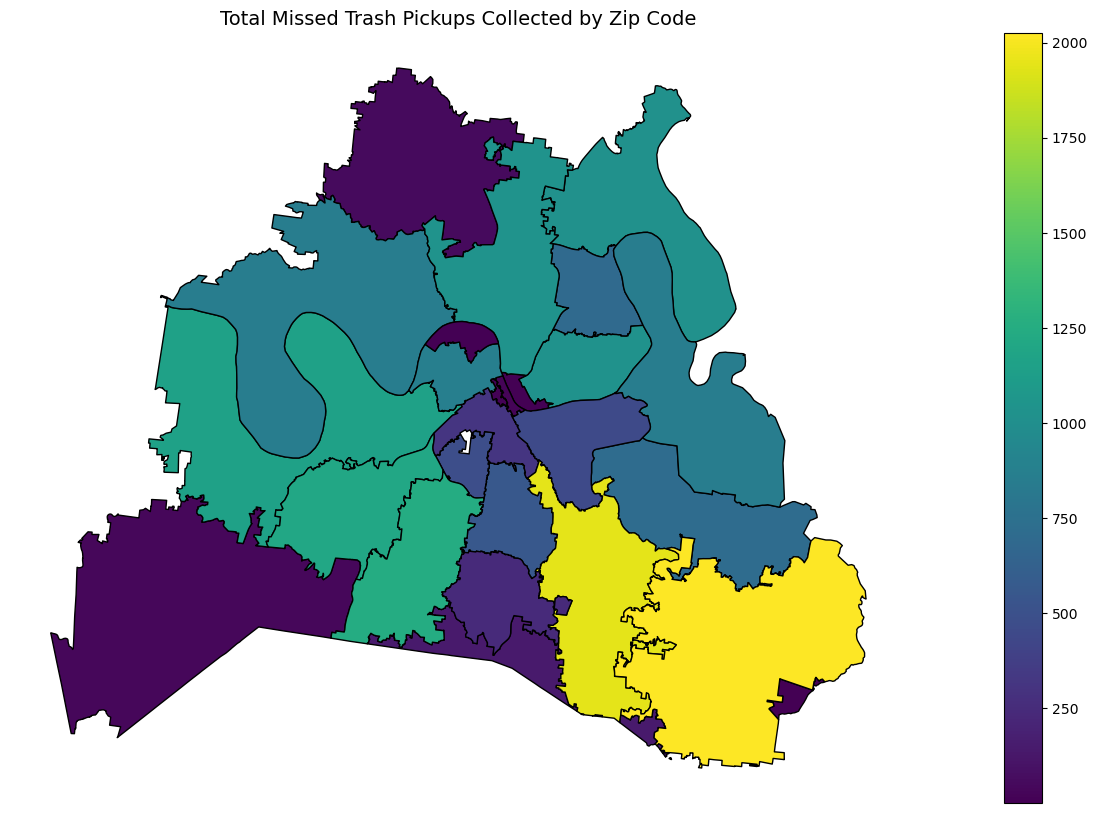

In [23]:
#Missed Pickups Map
trash_misses_map = trash_miss.groupby('Zip Code')['Number Missed'].sum().to_frame().reset_index()
trash_misses_map = pd.merge(left = zipcodes, right = trash_misses_map, 
                    left_on = 'zip', 
                    right_on = 'Zip Code')
fig, ax = plt.subplots(figsize=(25,10))
trash_misses_map.plot(column = 'Number Missed',
              edgecolor = 'black',
              legend = True,
              ax = ax)
plt.title('Total Missed Trash Pickups Collected by Zip Code', fontsize = 14)
ax.axis('off');

## Make a heat map that shows the most total fines by zip code.

In [26]:
#Total Fines Calculation
total_fines_by_zip = trash_miss.groupby('Zip Code').sum()

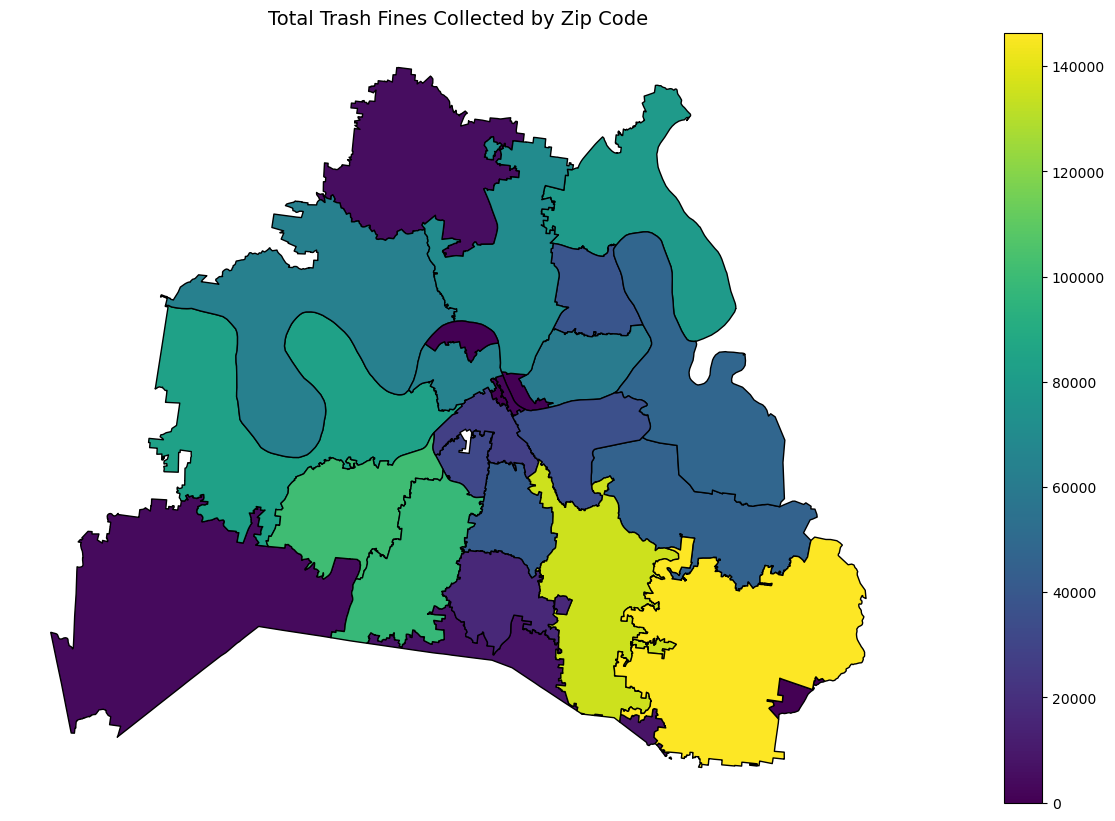

In [25]:
#Total Fines Map
trash_fines_map = trash_miss.groupby('Zip Code')['Total Fines'].sum().to_frame().reset_index()
trash_fines_map = pd.merge(left = zipcodes, right = trash_fines_map, 
                    left_on = 'zip', 
                    right_on = 'Zip Code')
fig, ax = plt.subplots(figsize=(25,10))
trash_fines_map.plot(column = 'Total Fines',
              edgecolor = 'black',
              legend = True,
              ax = ax)
plt.title('Total Trash Fines Collected by Zip Code', fontsize = 14)
ax.axis('off');

## How do metro crews compare to the contractor's performance?

In [28]:
all_hauls_missed = trash.loc[(trash['Request'] == 'Trash - Curbside/Alley Missed Pickup') | (trash['Miss_In_Description'] == 'Miss')]

In [29]:
hauler_perf = all_hauls_missed.groupby('Trash Hauler')['Request Number'].count().to_frame().reset_index()

In [30]:
hauler_routes = trash.groupby('Trash Hauler')['Trash Route'].nunique().to_frame().reset_index()

In [31]:
hauler_routes

,Trash Hauler,Trash Route
0,Metro,35
1,Red River,126
2,Waste Ind,16


In [32]:
hauler_merged= pd.merge(hauler_routes, hauler_perf, on = 'Trash Hauler', how = 'inner')

In [33]:
hauler_merged.columns = ['Hauler','Number of Routes','Number of Miss Complaints']

In [34]:
hauler_merged['Avg Misses per Route'] = (hauler_merged['Number of Miss Complaints'] / hauler_merged['Number of Routes']).round(2)

In [35]:
hauler_merged

,Hauler,Number of Routes,Number of Miss Complaints,Avg Misses per Route
0,Metro,35,3022,86.34
1,Red River,126,12838,101.89
2,Waste Ind,16,1128,70.50


## How much does each trash hauler owe?
* Red River owed: $919,400

* Metro owed: $216,200

* Waste Ind owed: $76,200

In [39]:
#How much does Red River owe
Red_River = trash.loc[trash['Trash Hauler'] == 'Red River']
Red_River_Miss = Red_River.loc[(Red_River.Request == 'Trash - Curbside/Alley Missed Pickup') | (Red_River.Miss_In_Description == 'Miss')]
Red_River_Fines = ((Red_River_Miss['Incident Address'].value_counts()-1)*200).to_frame().reset_index()
Red_River_Fines['count'].sum()

np.int64(919400)

In [37]:
#How much does Metro owe
Metro = trash.loc[trash['Trash Hauler'] == 'Metro']
Metro_Miss = Metro.loc[(Metro.Request == 'Trash - Curbside/Alley Missed Pickup') | (Metro.Miss_In_Description == 'Miss')]
Metro_Fines = ((Metro_Miss['Incident Address'].value_counts()-1)*200).to_frame().reset_index()
Metro_Fines['count'].sum()

np.int64(216200)

In [38]:
#How much does Waste Ind owe
Waste_Ind = trash.loc[trash['Trash Hauler'] == 'Waste Ind']
Waste_Ind_Miss = Waste_Ind.loc[(Waste_Ind.Request == 'Trash - Curbside/Alley Missed Pickup') | (Waste_Ind.Miss_In_Description == 'Miss')]
Waste_Ind_Fines = ((Waste_Ind_Miss['Incident Address'].value_counts()-1)*200).to_frame().reset_index()
Waste_Ind_Fines['count'].sum()

np.int64(76200)

## What were the total missed pickup by route?

In [ ]:
trash_misses = trash.loc[(trash['Request'] == 'Trash - Curbside/Alley Missed Pickup') 
                        |(trash['Miss_In_Description'] == 'Miss')]
trash_misses['Trash Route'].value_counts().to_frame().reset_index()